### Default simulation parameters for the Glasma and the Wong solvers

In [1]:
import numpy as np

# hbar * c [GeV * fm]
hbarc = 0.197326 

# Simulation box 
L = 10      
N = 512  
# N = 1024  
tau_sim = 1.5
DTS = 8     

# Glasma fields
su_group = 'su3'

Qs = 2        
ns = 50    
factor = 0.8        
g2mu = Qs / factor     
g = np.pi * np.sqrt(1 / np.log(Qs / 0.2))          		
mu = g2mu / g**2          	
ir = 0.1 * g**2 * mu  
 
uv = 10.0           

# Wong solver 
mass = 1   
tau_form = 0   
pT = 2   
ntp = 10**5  
nevents = 3    
boundary = 'periodic'       

### Set environment variables

In [2]:
import os
os.environ["MY_NUMBA_TARGET"] = "cuda"
os.environ["PRECISION"] = "double"
os.environ["GAUGE_GROUP"] = su_group

# Import relevant modules
import sys
sys.path.append('..')

# Glasma modules
import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False

import curraun.su as su
from curraun.numba_target import use_cuda
if use_cuda:
    from numba import cuda

# Wong modules
from curraun import wong
wong.BOUNDARY = boundary
wong.CUB_MOM = False
from curraun.wong import init_mom_toy, init_pos

# Dictionary with parameters
p = {}

Using CUDA
Using SU(3)
Using double precision
Using double precision


#### Initialization of color charge

In [4]:
from scipy.stats import unitary_group

# gell-mann matrices

gm = [
    [[0, 1, 0], [1, 0, 0], [0, 0, 0]],
    [[0, -1j, 0], [1j, 0, 0], [0, 0, 0]],
    [[1, 0, 0], [0, -1, 0], [0, 0, 0]],
    [[0, 0, 1], [0, 0, 0], [1, 0, 0]],
    [[0, 0, -1j], [0, 0, 0], [1j, 0, 0]],
    [[0, 0, 0], [0, 0, 1], [0, 1, 0]],
    [[0, 0, 0], [0, 0, -1j], [0, 1j, 0]],
    [[1 / np.sqrt(3), 0, 0], [0, 1 / np.sqrt(3), 0], [0, 0, -2 / np.sqrt(3)]]
]

T = np.array(gm) / 2.0

def init_charge(q3):
    """
        Step 1: specific random color vector
    """
    # These choices correspond to q2=4, since with q3=10/3 this would be a classical quark
    if q3 == 10/3:
        q0 = [0., 0., 0., 0., -1.69469, 0., 0., -1.06209]
    elif q3==3:
        q0 = [0., 0., 0., 0., -1.76858, 0., 0., -0.9339]
    elif q3==4:
        q0 = [0., 0., 0., 0., -1.45887, 0., 0., -1.3681]
    Q0 = np.einsum('ijk,i', T, q0)

    """
        Step 2: create a random SU(3) matrix to rotate Q.
    """
    
    V = unitary_group.rvs(3)
    detV = np.linalg.det(V)
    U = V / detV ** (1 / 3)
    Ud = np.conj(U).T

    Q = np.einsum('ab,bc,cd', U, Q0, Ud)

    """
        Step 3: Project onto color components
    """

    q = 2 * np.einsum('ijk,kj', T, Q)
    return np.real(q)

#### Version 1
Run with $q_2=4/3$ and $q_3=3, 10/3, 4$ where $Q^0$ is chosen by hand in order to fullfill these relations

In [4]:
import pickle
from tqdm import tqdm

# Simulation routine
def simulate(p, ev): 
    q3 = p["q3"]

    output = {}
    output["parameters"] = p.copy()

    # Derived parameters
    a = L / N
    E0 = N / L * hbarc
    DT = 1.0 / DTS
    formt = int(tau_form / a * DTS)
    maxt = int(tau_sim / a * DTS)

    # Initialize Glasma fields
    s = core.Simulation(N, DT, g)
    va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    initial.init(s, va, vb)

    # Initialize the Wong solver
    wong_solver = wong.WongSolver(s, ntp)
    x0s, p0s, q0s = np.zeros((ntp, 3)), np.zeros((ntp, 5)), np.zeros((ntp, su.ALGEBRA_ELEMENTS))
    masses = mass / E0 * np.ones(ntp)

    for i in range(ntp):
        x0, p0, q0 = init_pos(s.n), init_mom_toy('pT', pT / E0), init_charge(q3)
        x0s[i, :], p0s[i, :], q0s[i, :] = x0, p0, q0

    wong_solver.initialize(x0s, p0s, q0s, masses)

    psq = np.zeros((maxt-formt, 4)) 
    # pcub = np.zeros((maxt-formt, 3))

    with tqdm(total=maxt) as pbar:
        for t in range(maxt):
            # Evolve Glasma fields
            core.evolve_leapfrog(s)

            # Solve Wong's equations
            if t>=formt:  
                psq_wong = wong_solver.p_sq_mean
                psq[t-formt, :] = psq_wong * E0**2

                # pcub_wong = wong_solver.p_cub_mean 
                # pcub[t-formt, :] = pcub_wong * E0**3

                # p = wong_solver.p.copy()
                # for tp in range(ntp):
                #     pcubx = (p[tp, 1]-p0s[tp,1])**3
                #     pcuby = (p[tp, 2]-p0s[tp,2])**3
                #     pcubz = (p[tp, 4]-p0s[tp,4])**3

                # pcub[t-formt] = [np.mean(pcubx)* E0**3, np.mean(pcuby)* E0**3, np.mean(pcubz)* E0**3] 

                wong_solver.evolve()
                wong_solver.compute_mom_broad()

            pbar.set_description("Event " + str(ev+1))
            pbar.update(1)

    output["psq"] = psq
    # output["pcub"] = pcub

    return output

In [5]:
q3s = [3, 10/3, 4]
# q3s = [10/3]

psq = {}
# pcub = {}

for q3 in q3s:
    p["q3"] =  q3
    print(p["q3"])

    psqs = []
    # pcubs = []
    for ev in range(nevents):
        output = simulate(p, ev)
        psqs.append(output["psq"])
        # pcubs.append(output["pcub"])

    psq[q3] = np.mean(psqs, axis=0)
    # pcub[q3] = np.mean(pcubs, axis=0)

formt, maxt = int(tau_form / L * N * DTS), int(tau_sim / L * N * DTS)
tau = np.linspace(tau_form, tau_sim, maxt-formt)

output = {}
output["psq"], output["tau"] = psq, tau
# output["pcub"] = pcub
output["q3s"] = q3s

filename = 'mom_broad_q3_dep.pickle'
with open(filename, 'wb') as handle:
    pickle.dump(output, handle)

Event 3: 100%|██████████| 614/614 [03:20<00:00,  3.07it/s]


#### Version 2
Run with fixed $q_2$ and brute force color charges having this $q_2$ and free $q_3$

- - -
First, initialize brute force color charges with fixed $q_2$ using ```Numba``` and save the color vectors to file

In [2]:
import numpy as np

def init_charge_brute_force(q2=4):

    # color charges randomly distributed on a 8-dimensional hypersphere with radius fixed by quadratic Casimir r^2=q2
    # q2 = 4/3
    r = np.sqrt(q2)
    phi = np.random.uniform(0, 2 * np.pi, 7)
    Q1 = r * np.cos(phi[0])
    Q2 = r * np.sin(phi[0])*np.cos(phi[1])
    Q3 = r * np.sin(phi[0])*np.sin(phi[1])*np.cos(phi[2])
    Q4 = r * np.sin(phi[0])*np.sin(phi[1])*np.sin(phi[2])*np.cos(phi[3])
    Q5 = r * np.sin(phi[0])*np.sin(phi[1])*np.sin(phi[2])*np.sin(phi[3])*np.cos(phi[4])
    Q6 = r * np.sin(phi[0])*np.sin(phi[1])*np.sin(phi[2])*np.sin(phi[3])*np.sin(phi[4])*np.cos(phi[5])
    Q7 = r * np.sin(phi[0])*np.sin(phi[1])*np.sin(phi[2])*np.sin(phi[3])*np.sin(phi[4])*np.sin(phi[5])*np.cos(phi[6])
    Q8 = r * np.sin(phi[0])*np.sin(phi[1])*np.sin(phi[2])*np.sin(phi[3])*np.sin(phi[4])*np.sin(phi[5])*np.sin(phi[6])
    q0 = np.array([Q1, Q2, Q3, Q4, Q5, Q6, Q7, Q8])

    return q0

In [3]:
import os
os.environ["MY_NUMBA_TARGET"] = "numba"
os.environ["GAUGE_GROUP"] = 'su3'

import sys
sys.path.append('..')

import curraun.su as su

from numba.core.errors import NumbaPerformanceWarning
import warnings

warnings.simplefilter('ignore', category=NumbaPerformanceWarning)

Using SU(3)
Using Numba
Using double precision


In [5]:
ntrials = 10**6
# q2 = 4
q2 = 4/3
q3s, q0s = [], []
for n in range(ntrials):
    q0 = init_charge_brute_force(q2)
    q0s.append(q0)
    Q0 = su.get_algebra_element(q0)
    q2, q3 = su.casimir_fundamental_brute_force(Q0)
    c2, c3 = su.casimir_fundamental(Q0)
    q3s.append(q3)
q3s, q0s = np.array(q3s), np.array(q0s)

In [6]:
import matplotlib.pyplot as plt
plt.style.use('nord_theme_light.mpltstyle')
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["text.usetex"] = False

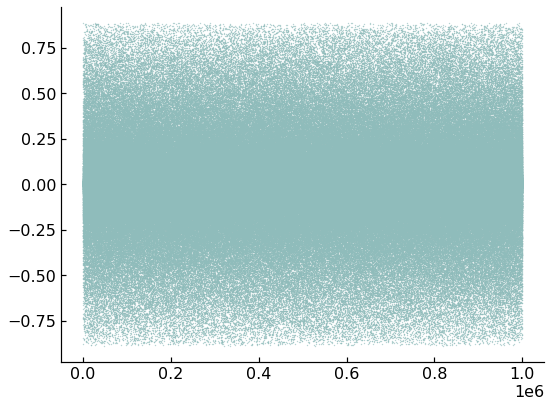

In [7]:
plt.plot(q3s, linewidth=0, markersize=0.3, marker='o',mfc='none')
plt.tight_layout()

In [8]:
import pickle

output = {}
output["q2"], output["q0s"] = q2, q0s
output["q3s"] = q3s

filename = 'brute_force_q2_' + str(round(q2,2)) + '.pickle'
with open(filename, 'wb') as handle:
    pickle.dump(output, handle)

- - -
Then, extract a few initial color vectors for $q_3$ values of interest. 

In [1]:
import pickle
import numpy as np

# q2 = 4.0
q2 = 1.33
brute_force_q = pickle.load(open('results/brute_force_q2_' + str(q2) + '.pickle', 'rb'))
q3s, q0s = brute_force_q["q3s"], brute_force_q["q0s"]

In [2]:
if q2==4.0:
    q3s_sim = [0, 1, 2, 3, 4]
else:
    q3s_sim = [0, 0.2, 0.4, 0.6, 0.8]

# test runs
# q3s_sim = [0]

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

q0s_sim = np.zeros((len(q3s_sim), 8))
for (q3index, q3value) in enumerate(q3s_sim):
    q0s_sim[q3index] = q0s[find_nearest(q3s, q3value)]

In [3]:
from scipy.stats import unitary_group

# gell-mann matrices

gm = [
    [[0, 1, 0], [1, 0, 0], [0, 0, 0]],
    [[0, -1j, 0], [1j, 0, 0], [0, 0, 0]],
    [[1, 0, 0], [0, -1, 0], [0, 0, 0]],
    [[0, 0, 1], [0, 0, 0], [1, 0, 0]],
    [[0, 0, -1j], [0, 0, 0], [1j, 0, 0]],
    [[0, 0, 0], [0, 0, 1], [0, 1, 0]],
    [[0, 0, 0], [0, 0, -1j], [0, 1j, 0]],
    [[1 / np.sqrt(3), 0, 0], [0, 1 / np.sqrt(3), 0], [0, 0, -2 / np.sqrt(3)]]
]

T = np.array(gm) / 2.0

def init_charge(q0):
    """
        Step 1: specific random color vector
    """
    Q0 = np.einsum('ijk,i', T, q0)

    """
        Step 2: create a random SU(3) matrix to rotate Q.
    """
    
    V = unitary_group.rvs(3)
    detV = np.linalg.det(V)
    U = V / detV ** (1 / 3)
    Ud = np.conj(U).T

    Q = np.einsum('ab,bc,cd', U, Q0, Ud)

    """
        Step 3: Project onto color components
    """

    q = 2 * np.einsum('ijk,kj', T, Q)
    return np.real(q)

- - -

In [4]:
import numpy as np

# hbar * c [GeV * fm]
hbarc = 0.197326 

# Simulation box 
L = 10      
N = 512  
# N = 1024  
tau_sim = 1.5
DTS = 8     

# Glasma fields
su_group = 'su3'

Qs = 2        
ns = 50    
factor = 0.8        
g2mu = Qs / factor     
g = np.pi * np.sqrt(1 / np.log(Qs / 0.2))          		
mu = g2mu / g**2          	
ir = 0.1 * g**2 * mu  
 
uv = 10.0           

# Wong solver 
# mass = 1   
# tau_form = 0   
# pT = 2  

# test with a jet
quark = 'jet'
mass = 1   
tau_form = 0   
pT = 5 
nevents = 3   

# charm quarks
# quark = 'charm'    
# mass = 1.275       
# tau_form = 1/(2*mass)*hbarc
# pT = 2
# nevents = 3 
# tau_sim += tau_form

# very massive quark
# quark = 'infmass'    
# mass = 100       
# tau_form = 0
# pT = 2
# nevents = 3 

ntp = 10**5  
# nevents = 5    
boundary = 'periodic'       

In [5]:
import os
os.environ["MY_NUMBA_TARGET"] = "cuda"
os.environ["PRECISION"] = "double"
os.environ["GAUGE_GROUP"] = su_group

# Import relevant modules
import sys
sys.path.append('..')

# Glasma modules
import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False

import curraun.su as su
from curraun.numba_target import use_cuda
if use_cuda:
    from numba import cuda

# Wong modules
from curraun import wong
wong.BOUNDARY = boundary
wong.CUB_MOM = False
from curraun.wong import init_mom_toy, init_pos

# Dictionary with parameters
p = {}

Using CUDA
Using SU(3)
Using double precision
Using double precision


In [6]:
import pickle
from tqdm import tqdm

# Simulation routine
def simulate(p, ev): 
    q0 = p["q0"]

    output = {}
    output["parameters"] = p.copy()

    # Derived parameters
    a = L / N
    E0 = N / L * hbarc
    DT = 1.0 / DTS
    formt = int(tau_form / a * DTS)
    maxt = int(tau_sim / a * DTS)

    # Initialize Glasma fields
    s = core.Simulation(N, DT, g)
    va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    initial.init(s, va, vb)

    # Initialize the Wong solver
    wong_solver = wong.WongSolver(s, ntp)
    x0s, p0s, q0s = np.zeros((ntp, 3)), np.zeros((ntp, 5)), np.zeros((ntp, su.ALGEBRA_ELEMENTS))
    masses = mass / E0 * np.ones(ntp)

    for i in range(ntp):
        x0, p0, q0 = init_pos(s.n), init_mom_toy('pT', pT / E0), init_charge(q0)
        x0s[i, :], p0s[i, :], q0s[i, :] = x0, p0, q0

    wong_solver.initialize(x0s, p0s, q0s, masses)

    psq = np.zeros((maxt-formt, 4)) 

    with tqdm(total=maxt) as pbar:
        for t in range(maxt):
            # Evolve Glasma fields
            core.evolve_leapfrog(s)

            # Solve Wong's equations
            if t>=formt:  
                psq_wong = wong_solver.p_sq_mean
                psq[t-formt, :] = psq_wong * E0**2

                wong_solver.evolve()
                wong_solver.compute_mom_broad()

            pbar.set_description("Event " + str(ev+1))
            pbar.update(1)

    output["psq"] = psq

    return output

In [7]:
psq = {}

for (q3index, q3value) in enumerate(q3s_sim):
    p["q0"] = q0s_sim[q3index, :]
    print('q3=', q3value)

    psqs = []
    for ev in range(nevents):
        output = simulate(p, ev)
        psqs.append(output["psq"])

    psq[q3value] = np.mean(psqs, axis=0)

formt, maxt = int(tau_form / L * N * DTS), int(tau_sim / L * N * DTS)
# tau = np.linspace(tau_form, tau_sim, maxt-formt)
tau = np.linspace(0, tau_sim-tau_form, maxt-formt)

output = {}
output["psq"], output["tau"] = psq, tau
output["q2"], output["q3s"] = q2, q3s_sim

# filename = 'mom_broad_brute_force_q2_' + str(q2) + '_q3_dep.pickle'
# test
filename = 'results/mom_broad_brute_force_q2_' + str(q2) + '_q3_dep_' + quark + '_pT_' + str(pT) + '.pickle'
with open(filename, 'wb') as handle:
    pickle.dump(output, handle)

q3= 0


Event 3: 100%|██████████| 614/614 [02:27<00:00,  4.16it/s]


q3= 0.2


Event 3: 100%|██████████| 614/614 [02:24<00:00,  4.25it/s]


q3= 0.4


Event 3: 100%|██████████| 614/614 [02:23<00:00,  4.27it/s]


q3= 0.6


Event 3: 100%|██████████| 614/614 [02:25<00:00,  4.22it/s]


q3= 0.8


Event 3: 100%|██████████| 614/614 [02:24<00:00,  4.26it/s]
